In [3]:
import tensorflow as tf
import numpy as np

In [12]:
ones_2d = np.ones((5,5))
weight_2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
strides_2d = [1, 1, 1, 1]

in_2d = tf.constant(ones_2d, dtype=tf.float32)
filter_2d = tf.constant(weight_2d, dtype=tf.float32)

in_width = int(in_2d.shape[0])
in_height = int(in_2d.shape[1])

filter_width = int(filter_2d.shape[0])
filter_height = int(filter_2d.shape[1])

input_2d   = tf.reshape(in_2d, [1, in_height, in_width, 1])
kernel_2d = tf.reshape(filter_2d, [filter_height, filter_width, 1, 1])

output_2d = tf.squeeze(tf.nn.conv2d(input_2d, kernel_2d, strides=strides_2d, padding='SAME'))

In [16]:
with tf.Session() as sess:
    print sess.run(filter_2d)
    print sess.run(kernel_2d)

[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[[[1.]]

  [[2.]]

  [[3.]]]


 [[[4.]]

  [[5.]]

  [[6.]]]


 [[[7.]]

  [[8.]]

  [[9.]]]]


In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import sys
sys.path.append('..')

from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
import tensorflow as tf

import kernels

FILENAME = 'data/friday.jpg'

def read_one_image(filename):
    """ This is just to demonstrate how to open an image in TensorFlow,
    but it's actually a lot easier to use Pillow 
    """
    filename_queue = tf.train.string_input_producer([filename])
    image_reader = tf.WholeFileReader()
    _, image_file = image_reader.read(filename_queue)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.cast(image, tf.float32) / 256.0 # cast to float to make conv2d work
    return image

def convolve(image, kernels, rgb=True, strides=[1, 3, 3, 1], padding='SAME'):
    images = [image[0]]
    for i, kernel in enumerate(kernels):
        filtered_image = tf.nn.conv2d(image, kernel, strides=strides, padding=padding)[0]
        if i == 2:
            filtered_image = tf.minimum(tf.nn.relu(filtered_image), 255)
        images.append(filtered_image)
    return images

def get_real_images(images):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        images = sess.run(images)
        coord.request_stop()
        coord.join(threads)
    return images

def show_images(images, rgb=True):
    gs = gridspec.GridSpec(1, len(images))
    for i, image in enumerate(images):
        plt.subplot(gs[0, i])
        if rgb:
            plt.imshow(image)
        else: 
            image = image.reshape(image.shape[0], image.shape[1])
            plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

def main():
    rgb = False
    if rgb:
        kernels_list = [kernels.BLUR_FILTER_RGB, kernels.SHARPEN_FILTER_RGB, kernels.EDGE_FILTER_RGB, 
                    kernels.TOP_SOBEL_RGB, kernels.EMBOSS_FILTER_RGB]
    else:
        kernels_list = [kernels.BLUR_FILTER, kernels.SHARPEN_FILTER, kernels.EDGE_FILTER, 
                    kernels.TOP_SOBEL, kernels.EMBOSS_FILTER]

    image = read_one_image(FILENAME)
    if not rgb:
        image = tf.image.rgb_to_grayscale(image)
    image = tf.expand_dims(image, 0) # to make it into a batch of 1 element
    images = convolve(image, kernels_list, rgb)
    images = get_real_images(images)
    show_images(images, rgb)

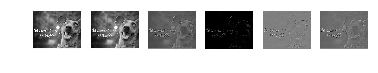

In [23]:
main()